In [1]:
from glob import glob
from os.path import join, dirname

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import cm, colors, patches, lines

from scipy import optimize, stats

from nilearn import image, plotting, masking
from nilearn.maskers import NiftiLabelsMasker

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
# import pingouin as pg

In [2]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [3]:
dir_root = join('/mnt/ext5/GP/fmri_data')
dir_stat = join(dir_root,'stats/AM/GLM.reward_per_trial/5.0s_shifted')
dir_mask = join(dir_root,'masks')

In [4]:
list_dlPFC_cTBS = [
    '09', '10', '18', '21', '22'
    , '24', '27', '34', '35', '36'
    , '38', '42', '57', '59', '62'
    , '66', '67'
]
list_M1_cTBS = [
    '08', '11', '17', '19', '20'
    , '26', '32', '33', '37', '39'
    , '40', '41', '56', '58', '61'
    , '63', '65'
]
## GP50은 GP26과 동일인물
list_dlPFC_20Hz = [
    '43', '44', '45', '46', '47'
    , '48', '49', '51', '53', '54'
    , '55'
#     , '50'
]
list_subj = sorted(list_dlPFC_cTBS+list_M1_cTBS+list_dlPFC_20Hz)

In [5]:
list_GA = []
list_ = glob(join('/mnt/ext5/GA/fmri_data/raw_data/GA??'))
for dname in list_:
    list_GA.append(dname.split('/')[-1])

In [6]:
dx = pd.DataFrame(index=list_GA)
dx['group'] = 'no_stim'

In [7]:
dy = pd.DataFrame()
for nn in list_subj:
    subj = 'GP%s'%nn
    group = 'DLPFC_cTBS' if nn in list_dlPFC_cTBS else ('M1_cTBS' if nn in list_M1_cTBS else 'DLPFC_20Hz')
    new_row = pd.Series(data=group, name=subj)

    dy = pd.concat(
        [dy, new_row.to_frame().T]
        , axis='index'
        , ignore_index=False
    )
dy = dy.rename({0:'group'}, axis='columns')

In [8]:
dz = pd.concat([dx, dy])
del dx, dy
dz

,group
GA01,no_stim
GA35,no_stim
GA26,no_stim
GA02,no_stim
GA18,no_stim
...,...
GP62,DLPFC_cTBS
GP63,M1_cTBS
GP65,M1_cTBS
GP66,DLPFC_cTBS


In [9]:
list_group = dz.group.unique().astype(str)
list_group

array(['no_stim', 'M1_cTBS', 'DLPFC_cTBS', 'DLPFC_20Hz'], dtype='<U10')

---

In [10]:
p_thresh = 5.e-2
thresh = stats.norm.isf(0.5*p_thresh)

---

Zstat.r01.prac.n30.nii
Zstat.r02.prac.n30.nii
Zstat.r03.prac.n30.nii


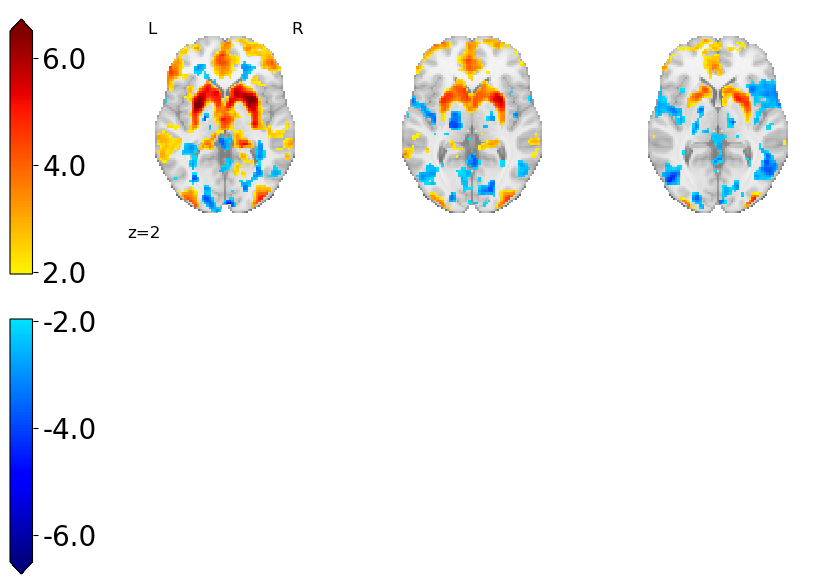

In [11]:
fig, axs = plt.subplots(ncols=3, figsize=(9,3))

for ii, fname in enumerate(sorted(glob(join(dir_stat.replace('GP','GA'),'Zstat.r??.prac.n??.nii')))):
    print(fname.split('/')[-1])
    run = fname.split('/')[-1].split('.')[1]
    ax = axs[ii]
    plotting.plot_stat_map(
        fname,
        threshold=thresh,
        display_mode='z', resampling_interpolation='continuous',
        black_bg=False,
        annotate=True if run=='r01' else False,
        cut_coords=[2],
        vmax=6.5,
        cmap='jet', colorbar=False, symmetric_cbar=True,
        axes=ax
    )
## =============================================== ##        
norm = colors.Normalize(vmin=-6.5, vmax=6.5)
## =============================================== ##    
### 컬러바 생성
array_cmap = cm.jet(range(cm.jet.N))[:int(norm(-thresh)*256)]
cmap_new = colors.ListedColormap(array_cmap)
colormapping = cm.ScalarMappable(
    norm=colors.Normalize(vmin=-6.5, vmax=-thresh), cmap=cmap_new
)
### 컬러바 삽입
cax = fig.add_axes([0.0, -1., .025, 0.85])
cbar = fig.colorbar(
    colormapping, extend='min',
    orientation='vertical',
    format='%.1f',
    cax=cax
)
cbar.ax.tick_params(labelsize=20)
## =============================================== ##    
### 컬러바 생성
array_cmap = cm.jet(range(cm.jet.N))[int(norm(thresh)*256):]
cmap_new = colors.ListedColormap(array_cmap)
colormapping = cm.ScalarMappable(
    norm=colors.Normalize(vmin=thresh, vmax=6.5), cmap=cmap_new
)
### 컬러바 삽입
cax = fig.add_axes([0.0, 0., .025, 0.85])
cbar = fig.colorbar(
    colormapping, extend='max', 
    orientation='vertical',
    format='%.1f',
    cax=cax
)
cbar.ax.tick_params(labelsize=20)

In [12]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/fMRI.fig.3i.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)

Zstat.r01.DLPFC_20Hz.n11.nii
Zstat.r01.DLPFC_cTBS.n17.nii
Zstat.r01.M1_cTBS.n17.nii
Zstat.r02.DLPFC_20Hz.n11.nii
Zstat.r02.DLPFC_cTBS.n17.nii
Zstat.r02.M1_cTBS.n17.nii
Zstat.r03.DLPFC_20Hz.n11.nii
Zstat.r03.DLPFC_cTBS.n17.nii
Zstat.r03.M1_cTBS.n17.nii


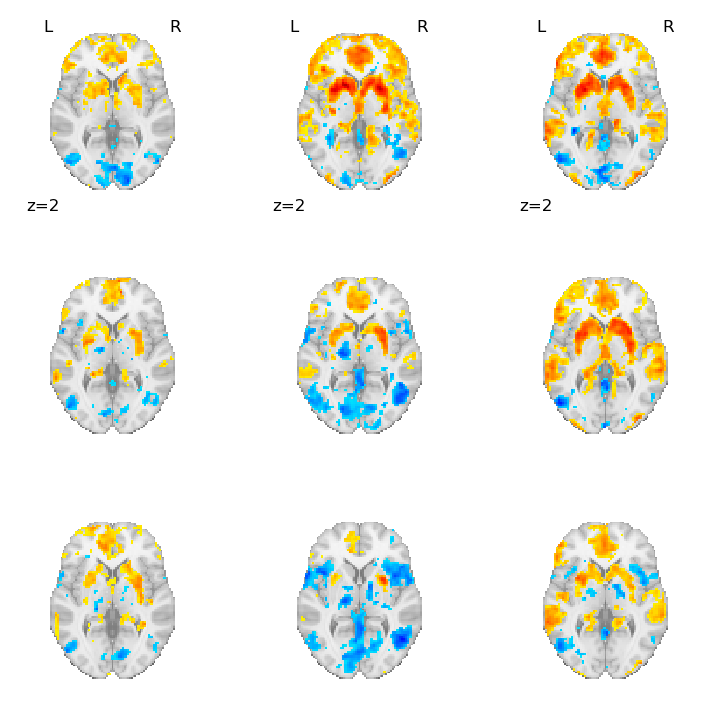

In [13]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9,9))
axs = np.concatenate(axs)

for ii, fname in enumerate(sorted(glob(join(dir_stat,'Zstat.r0?.*.n??.nii')))):
    print(fname.split('/')[-1])
    run = fname.split('/')[-1].split('.')[1]
    ax = axs[ii]
    plotting.plot_stat_map(
        fname,
        threshold=thresh,
        display_mode='z', resampling_interpolation='continuous',
        black_bg=False, annotate=True if run=='r01' else False,
        cut_coords=[2],
        vmax=6.5,
        cmap='jet', colorbar=False, symmetric_cbar=True,
#         title=fname,
        axes=ax
    )

In [14]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/fMRI.fig.3ii.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)

---

In [15]:
view_cut = {}
view_cut['sagittal'] = [-55, -22, -7]
view_cut['axial'] = [2]

/tmp/ipykernel_1035585/1933784639.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


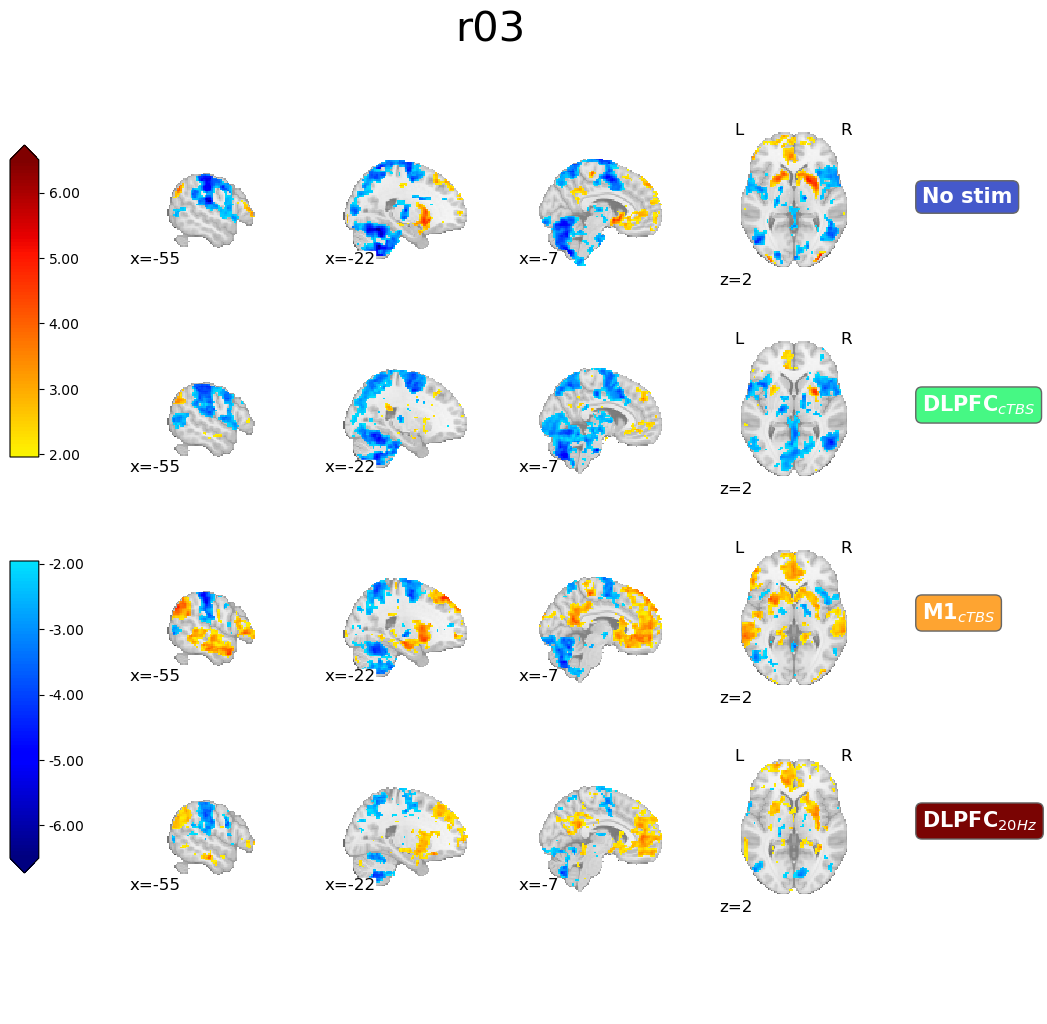

In [16]:
nrows, ncols = 4, 4
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.4*ncols,2.6*nrows))

run = 'r03'

for ii, group in enumerate(['no_stim', 'DLPFC_cTBS', 'M1_cTBS', 'DLPFC_20Hz']):
    for jj, coord in enumerate(view_cut['sagittal']):
        ax = axs[ii][jj]
        if group =='no_stim':
            fname_Zscr = glob(join(
                '/mnt/ext5/GA/fmri_data/stats/AM/GLM.reward_per_trial/5.0s_shifted'
                , 'Zstat.%s.prac.n??.nii'%run
            ))[0]
        else:
            fname_Zscr = glob(join(dir_stat,'Zstat.%s.%s.n??.nii'%(run,group)))[0]

#         ## positive
#         img_stat = image.math_img(
#             img1=fname_Zscr
#             , formula='(img1>0) * img1'
#         )

        ## positive & negative
        img_stat = fname_Zscr

        g = plotting.plot_stat_map(
            img_stat
            , threshold=thresh
            , display_mode='x'
            , black_bg=False
            , cut_coords=[coord]
            , vmax=6.5
            , cmap='jet', colorbar=False
            , axes=ax
        )
    for kk, coord in enumerate(view_cut['axial']):
        ax = axs[ii][jj+1+kk]

        ## positive & negative
        img_stat = fname_Zscr

        g = plotting.plot_stat_map(
            img_stat
            , threshold=thresh
            , display_mode='z'
            , black_bg=False
            , cut_coords=[coord]
            , vmax=6.5
            , cmap='jet', colorbar=False
            , axes=ax
        )

## 최대 최소 설정
vmax = 6.5
vmin = -6.5
norm = colors.Normalize(vmin=vmin, vmax=vmax)

################
## upper cmap ##
################

### 컬러바 생성
array_cmap = cm.jet(range(cm.jet.N))[int(norm(thresh)*256):]
cmap_new = colors.ListedColormap(array_cmap)
colormapping = cm.ScalarMappable(
    norm=colors.Normalize(vmin=thresh, vmax=vmax)
    , cmap=cmap_new
)
### 컬러바 삽입
# cax = fig.add_axes([0.05, .15, .015, .7])
cax = fig.add_axes([0.0, 0.55, .03, 0.3])
cbar = fig.colorbar(
    colormapping, extend='max'
    , orientation='vertical'
    , format='%.2f'
    , cax=cax)

################
## lower cmap ##
################

### 컬러바 생성
array_cmap = cm.jet(range(cm.jet.N))[:int(norm(-thresh)*256)]
cmap_new = colors.ListedColormap(array_cmap)
colormapping = cm.ScalarMappable(
    norm=colors.Normalize(vmin=vmin, vmax=-thresh)
    , cmap=cmap_new
)
### 컬러바 삽입
# cax = fig.add_axes([0.05, .15, .015, .7])
cax = fig.add_axes([0.0, 0.15, .03, 0.3])
cbar = fig.colorbar(
    colormapping, extend='min'
    , orientation='vertical'
    , format='%.2f'
    , cax=cax
)

## labeling
palette = cm.turbo(np.linspace(0.1,1.0,4))

dy = 0.20
## titles
for ii, group in enumerate(['No stim',r'DLPFC$_{cTBS}$',r'M1$_{cTBS}$',r'DLPFC$_{20Hz}$']):
    fig.text(
        0.95, 0.8-dy*ii, group
        , size=15, rotation=0
        , ha='left', va='center'
        , color='white', fontweight='bold'
        , bbox=dict(
            boxstyle='round'
            , ec=(0.4, 0.4, 0.4)
            , fc=palette[ii]
        )
    )

fig.suptitle(run, fontsize=30)
fig.tight_layout()

In [17]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/fMRI.fig.3a.%s.png'%run
    , dpi=600, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)